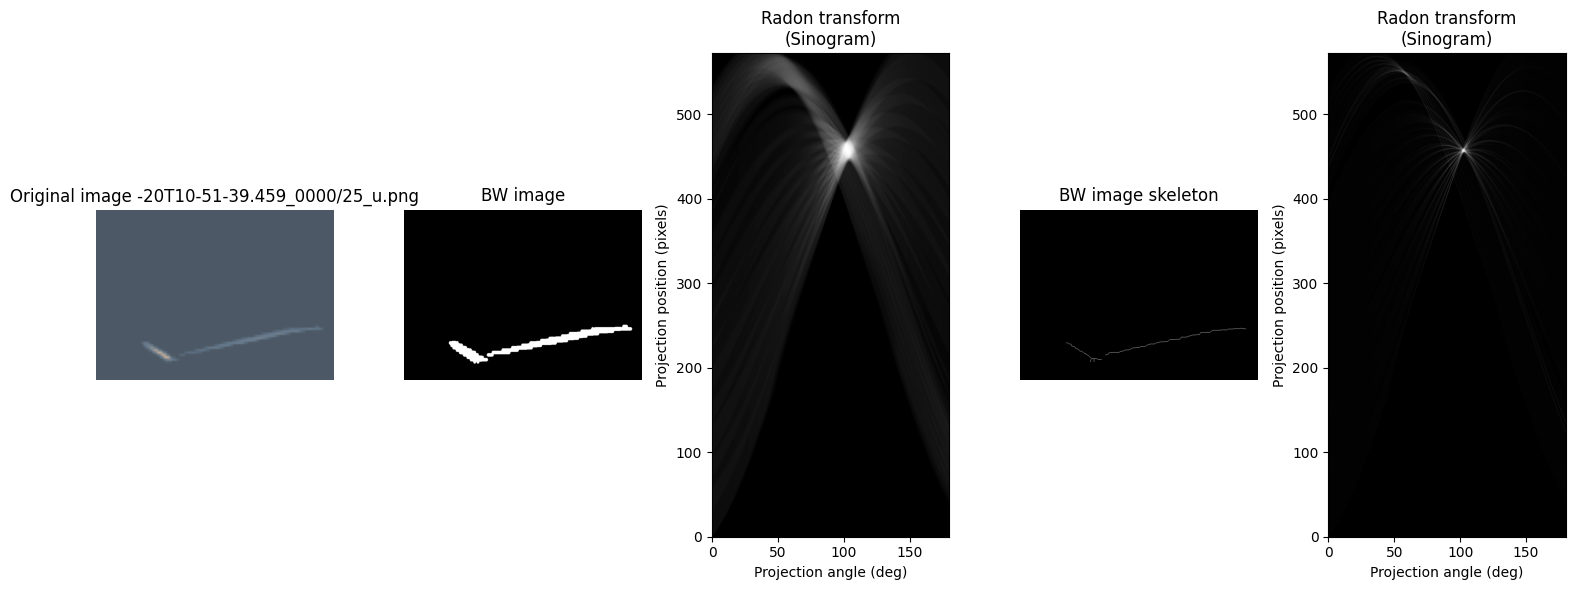

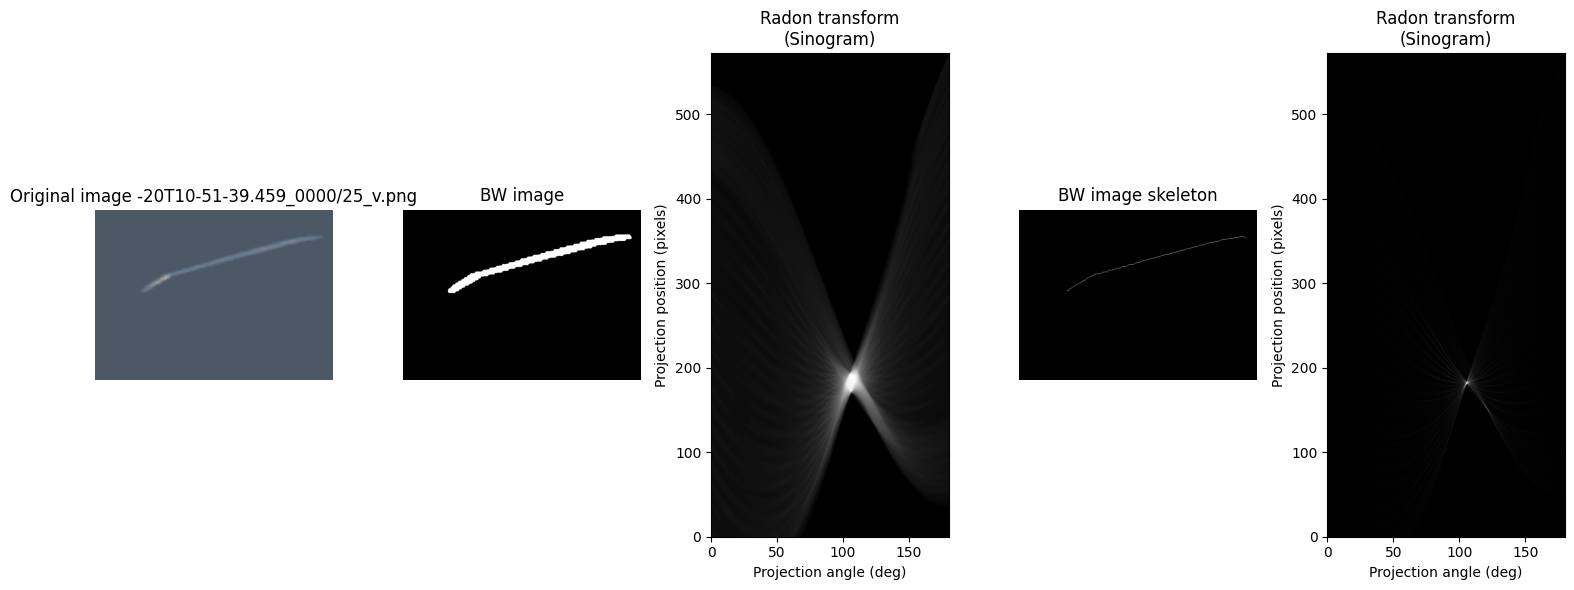

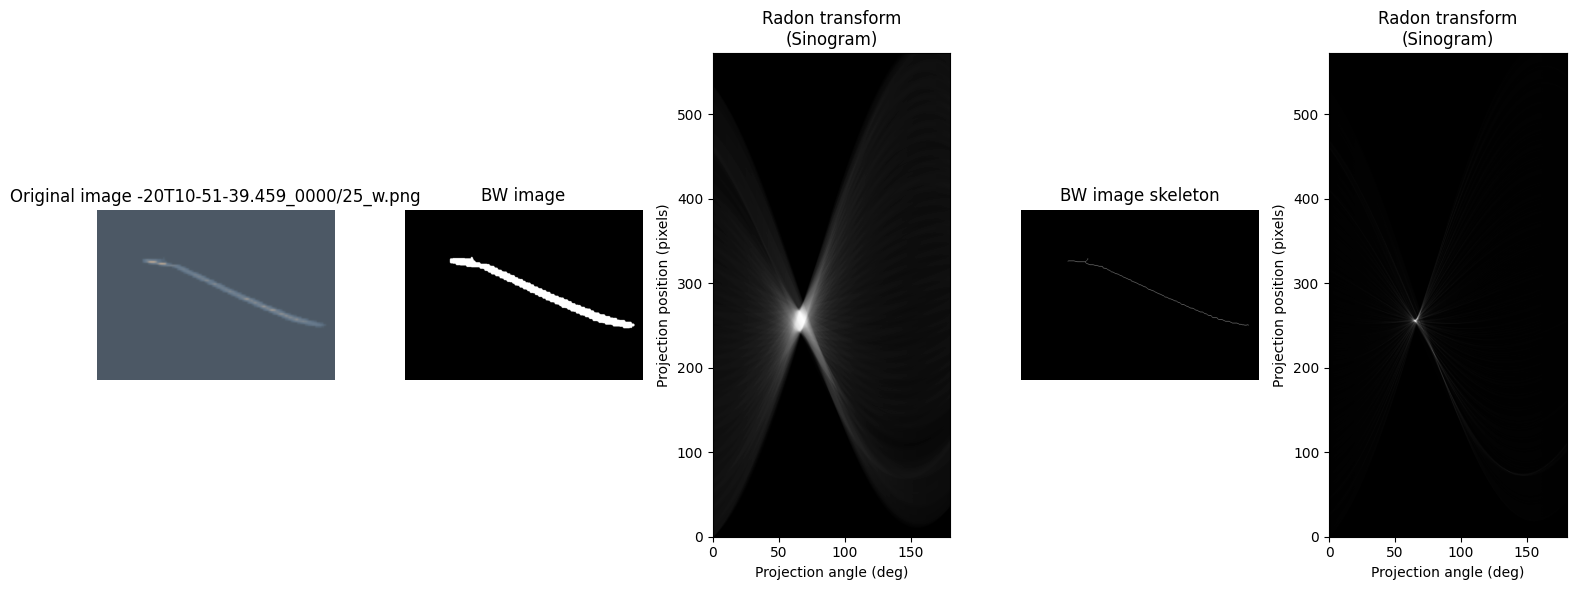

In [2]:
from matplotlib import cm
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.morphology import skeletonize
from src.openImage import openImage

from skimage.transform import radon, rescale


# Remove small shapes.
def cleanNoise(image, min_size_threshold=100):

    # Apply a different label for each shape.
    labeled_image, num_labels = ndimage.label(image)

    # Count the size of each labes which is the size of each shape. Remember to address the fact that 0 is not a real label and is background.
    sizes = np.bincount(labeled_image.ravel())

    # Exclude the background label (0) from the sizes array.
    sizes[0] = 0

    # Remove small connected components
    filtered_image = np.where(sizes[labeled_image] < min_size_threshold, 0, 1)

    return filtered_image


def computeRadon(image):

    max_shape = max(image.shape)

    theta = np.linspace(0.0, 180.0, max_shape, endpoint=False)
    sinogram = radon(image, theta=theta)
    dx, dy = 0.5 * 180.0 / max_shape, 0.5 / sinogram.shape[0]

    return dx, dy, sinogram

def fitImage(path_and_name_input, path_and_name_output=None):

    ################### PARAMETERS TO BE CHANGED ###################

    white_th = 0.35#0.15
    gaussian_sigma = 1.75

    ##############################################################

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    test_image.m_data = ndimage.gaussian_filter(test_image.m_data, gaussian_sigma)

    original_image = test_image.m_data


    # Black and white
    test_image.m_data = rgb2gray(test_image.m_data)

    grey_image = test_image.m_data

    # Turn completely black and white
    test_image.m_data = np.where(test_image.m_data < white_th, 0, 1)

    test_image.m_data = cleanNoise(test_image.m_data, 100)
    image_skelton = skeletonize(test_image.m_data)

    #####
    #image = rescale(test_image.m_data, scale=0.4, mode='reflect', channel_axis=None)
    #######

    # Create the canvas

    fig, axes = plt.subplots(1, 5, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(original_image)
    ax[0].set_title('Original image ' + path_and_name_input[70:])
    ax[0].set_axis_off()

    ax[1].imshow(test_image.m_data, cmap=cm.gray)
    ax[1].set_title('BW image')
    ax[1].set_axis_off()

    ### Radon ###

    dx, dy, sinogram = computeRadon(test_image.m_data)

    ############

    ax[2].set_title("Radon transform\n(Sinogram)")
    ax[2].set_xlabel("Projection angle (deg)")
    ax[2].set_ylabel("Projection position (pixels)")
    ax[2].imshow(
        sinogram,
        cmap=plt.cm.Greys_r,
        extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
        aspect='auto',
    )



    ### Radon skeleton ###

    dx, dy, sinogram = computeRadon(image_skelton)

    ######################

    ax[3].imshow(image_skelton, cmap=cm.gray)
    ax[3].set_title('BW image skeleton')
    ax[3].set_axis_off()

    ax[4].set_title("Radon transform\n(Sinogram)")
    ax[4].set_xlabel("Projection angle (deg)")
    ax[4].set_ylabel("Projection position (pixels)")
    ax[4].imshow(
        sinogram,
        cmap=plt.cm.Greys_r,
        extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
        aspect='auto',
    )



    plt.tight_layout()
    plt.savefig(path_and_name_output)



image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages2/"


image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"]
#image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25"]

image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages_radon/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))

